# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,os,shutil
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import interp1d
from IPython.display import display, Markdown
import pylhe, gzip, tempfile

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
files = {'SM': '../processFolders/pp2TT_sm/Events/run_01/events.lhe.gz', 
         'BSM' : '../processFolders/pp2TT_full/Events/run_02/events.lhe.gz'}
#          'BSM-QCD' : '../processFolders/pp2TT_fullQCD/Events/run_01/events.lhe.gz'}

In [3]:
# It is necessary to remove the < signs from the LHE files (in the generate line) before parsing with pylhe
events = {}
for label, fpath in files.items():
    fixedFile = tempfile.mkstemp(suffix='.lhe')
    os.close(fixedFile[0])
    fixedFile = fixedFile[1]
    with  gzip.open(fpath,'rt') as f:
        data = f.readlines()
        with open(fixedFile,'w') as newF:
            for l in data:
                if 'generate' in l:
                    continue
                newF.write(l)
        files[label] = fixedFile
    events[label] = pylhe.read_lhe(fixedFile)

        

In [4]:
mtt = {}
for mod,r in events.items():
    pT = []
    mTT = []
    for iev,ev in enumerate(r):
        for ptc in ev.particles:
            if abs(ptc.id) != 6: continue
            if ptc.id == 6:
                pA = np.array([ptc.px,ptc.py,ptc.pz,ptc.e])
            else:
                pB = np.array([ptc.px,ptc.py,ptc.pz,ptc.e])
        pT.append(max(np.linalg.norm(pA[0:3]),np.linalg.norm(pB[0:3])))
        mTT.append(np.sqrt((pA[-1]+pB[-1])**2-np.linalg.norm(pA[0:3]+pB[0:3])**2))
    mtt[mod] = {'pT' : pT, 'mTT' : mTT}

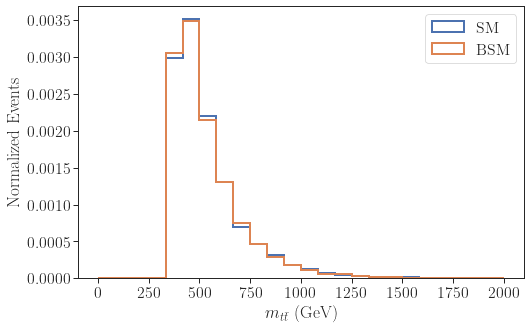

In [5]:
fig = plt.figure(figsize=(8,5))
bins = np.linspace(0.,2000.,25)
for mod in mtt:
    plt.hist(mtt[mod]['mTT'],label=mod,bins=bins,
             density=True,histtype='step',linewidth=2)
# plt.yscale('log')
plt.xlabel(r'$m_{t\bar{t}}$ (GeV)')
plt.ylabel('Normalized Events')
plt.legend()
plt.show()

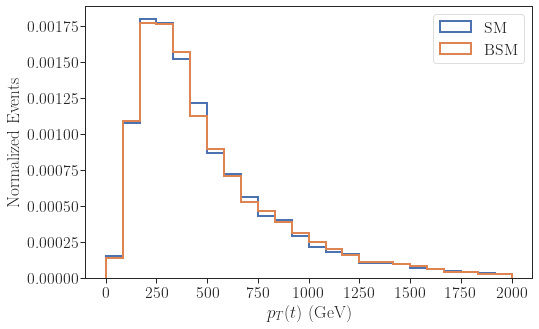

In [8]:
fig = plt.figure(figsize=(8,5))
bins = np.linspace(0.,2000.,25)
for mod in mtt:
    plt.hist(mtt[mod]['pT'],label=mod,bins=bins,
             density=True,histtype='step',linewidth=2)
# plt.yscale('log')
plt.xlabel(r'$p_T(t)$ (GeV)')
plt.ylabel('Normalized Events')
plt.legend()
plt.show()